In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compton import ComptonScattering, AdvancePhoton

def plot_turb(ax, x, y, ndens, Vx, Vy, Vz, width=2):
    ax.pcolormesh(x, y, ndens, cmap="inferno")
    ax.streamplot(
        x,
        y,
        Vx,
        Vy,
        color="w",
        density=2,
        linewidth=(Vx**2 + Vy**2 + Vz**2) / np.max(Vx**2 + Vy**2 + Vz**2) * width,
        arrowsize=1,
        arrowstyle="->",
    )

    ax.set(
        aspect=1,
        xlim=(x.min(), x.max()),
        ylim=(y.min(), y.max()),
    )

In [2]:
data = np.load("turb2d-256.npz")

In [3]:
xmin, xmax, ymin, ymax = -2500, 2500, -2500, 2500

x, y = data["x"], data["y"]
ndens = data["ndens"]

Vx, Vy, Vz = data["Vx"], data["Vy"], data["Vz"]

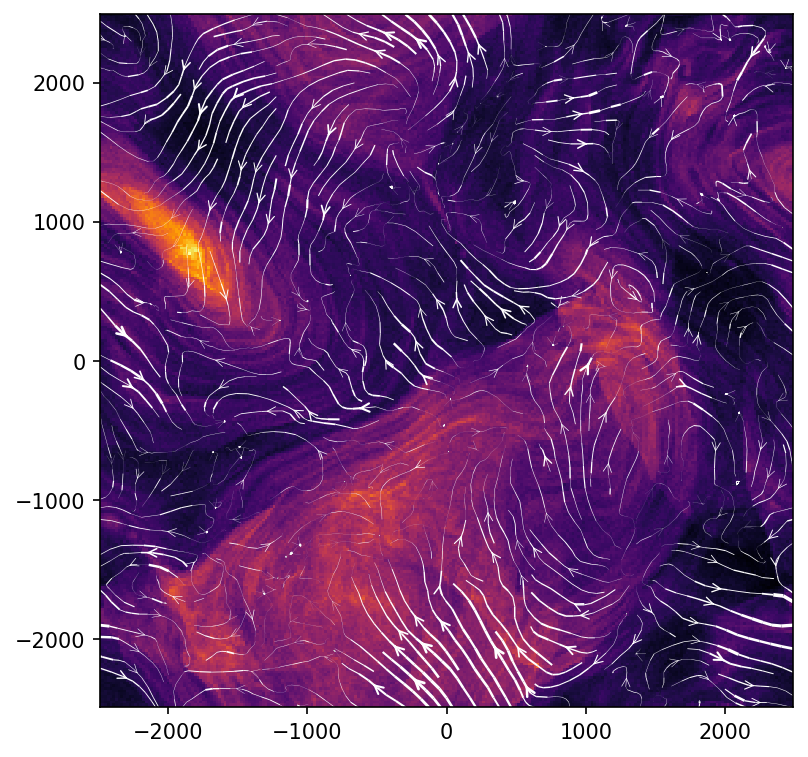

In [4]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

plot_turb(ax, x, y, ndens, Vx, Vy, Vz)

Photon momentum ($c=1$, speed of light is equal to $1$):

$\bm{P} = (E/c) \hat{\bm{k}}$,

where $E$ is photon's energy, and $\hat{\bm{k}}$ is a unit vector (direction of motion).

$|\bm{P}| = E/c$ -- length of the vector $\bm{P}$.

$\bm{P} / |\bm{P}| = \hat{\bm{k}}$

$\bm{x}_{\rm new} = \bm{x}_{\rm old} + \bm{k} c \Delta t$

In [20]:
sy, sx = ndens.shape

photon_pos = [np.array([0, 0, 0])]
photon_mom = np.array([0.2, 1, 2, 0])

photon_mom[1:] = photon_mom[1:] / np.linalg.norm(photon_mom[1:]) * photon_mom[0]

photon_pos_array, photon_mom_array = AdvancePhoton(
    np.array([0, 0, 0]),
    photon_mom,
    2,
    5000,
    20,
    Vx,
    Vy,
    Vz,
    xmin,
    xmax,
    ymin,
    ymax,
    sx,
    sy,
    False,
)

In [34]:
nphotons = 1000

photon_positions = []
photon_momenta = []

for _ in range(nphotons):
    photon_positions.append(np.array([0, 0, 0]))

    energy = np.random.random() * 0.1 + 0.1
    urand = np.random.random() * 2 - 1
    phirand = 2 * np.pi * np.random.random()

    kx = np.sqrt(1 - urand**2) * np.cos(phirand)
    ky = np.sqrt(1 - urand**2) * np.sin(phirand)
    kz = urand

    photon_momenta.append(energy * np.array([1, kx, ky, kz]))

photon_momenta

[array([0.17431862, 0.03605923, 0.11787375, 0.12325783]),
 array([ 0.12742062, -0.0887889 , -0.03689617, -0.0836135 ]),
 array([0.18278512, 0.0638517 , 0.00242166, 0.17125273]),
 array([ 0.15404854,  0.14474735,  0.02568668, -0.04603643]),
 array([ 0.10802398,  0.05190747, -0.00122874,  0.09472743]),
 array([ 0.1735969 ,  0.13166964,  0.08840335, -0.07059632]),
 array([ 0.15690435,  0.15165725,  0.03544839, -0.01903851]),
 array([ 0.16051178, -0.14004907,  0.00740719,  0.07807319]),
 array([ 0.11356711, -0.04691332,  0.08869313, -0.05319922]),
 array([ 0.15538702, -0.11273949,  0.10304225, -0.02858723]),
 array([0.16589723, 0.0385633 , 0.04861154, 0.15385604]),
 array([ 0.17461217, -0.0332582 , -0.00538944,  0.17133084]),
 array([ 0.18475876, -0.15168037,  0.09789374,  0.03931514]),
 array([ 0.11497577,  0.09113013, -0.01337187,  0.06881801]),
 array([ 0.10450867,  0.00198269, -0.0801737 , -0.06700976]),
 array([ 0.12817925,  0.00996991, -0.12609498,  0.02075038]),
 array([ 0.16446702,

In [35]:
final_photon_positions = []
final_photon_momenta = []

for photon_pos, photon_mom in zip(photon_positions, photon_momenta):
    final_photon_pos, final_photon_mom = AdvancePhoton(
        photon_pos,
        photon_mom,
        2,
        5000,
        20,
        Vx,
        Vy,
        Vz,
        xmin,
        xmax,
        ymin,
        ymax,
        sx,
        sy,
        False,
    )
    final_photon_positions.append(final_photon_pos)
    final_photon_momenta.append(final_photon_mom)

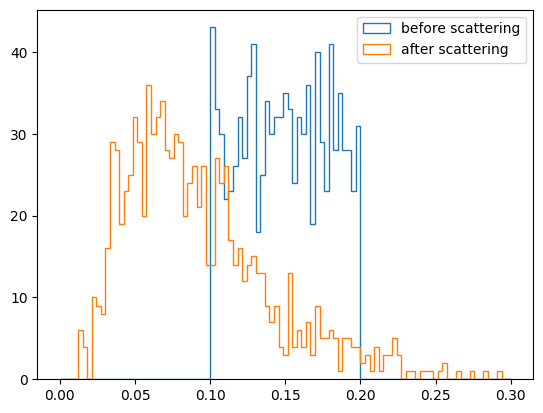

In [40]:
plt.hist(
    np.array(photon_momenta)[:, 0],
    bins=np.linspace(0, 0.3, 100),
    histtype="step",
    label="before scattering",
)
plt.hist(
    np.array(final_photon_momenta)[:, 0],
    bins=np.linspace(0, 0.3, 100),
    histtype="step",
    label="after scattering",
)

_ = plt.legend()

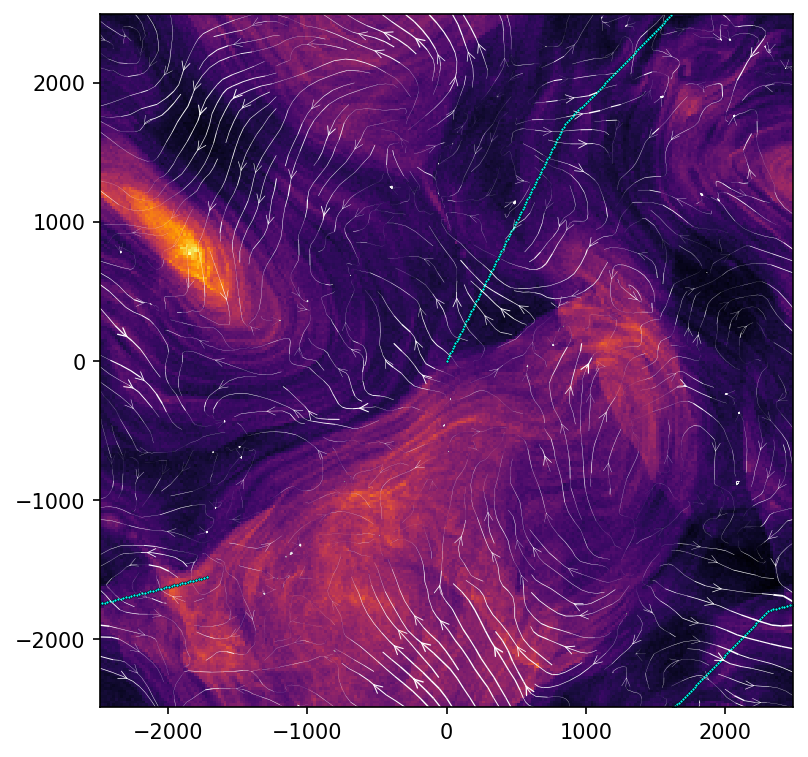

In [10]:
interval = 1

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

plot_turb(ax, x, y, ndens, Vx, Vy, Vz, width=1)

ax.scatter(
    photon_pos_array[:, 0][::interval],
    photon_pos_array[:, 1][::interval],
    color="cyan",
    s=2,
    edgecolor="k",
    lw=0.25,
)

# Task for Jan 19:

Knowing the `Vx`, `Vy`, `Vz` -- try to determine the "temperature" of the electron gas.

In [ ]:
np.sqrt(Vx**2 + Vy**2 + Vz**2).flatten()

array([0.45450791, 0.43422025, 0.46378442, ..., 0.35722875, 0.29605701,
       0.25872069], shape=(65536,))